# Sprint21　転移学習 　
### 自作CNNモデル及び転移学習によって分類タスク(果物の分類)を実施する
### 転移学習に用いるモデル：VGG16 , ResNet50 

### ライブラリインポート

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input ,Dense, Flatten
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
import itertools

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### データ準備関数

In [2]:
def data_prepare(limit, TRAIN_PATH = 'input/fruits-360/Training/'):
    
    train_ids = next(os.walk(TRAIN_PATH))[1]
    #train_idsから番号と文字列を取り出す
    num_and_name = dict()
    for n in range(len(train_ids)):
        #振り分け番号
        num_and_name[n] = train_ids[n]

    IMG_HEIGHT = 100
    IMG_WIDTH = 100
    IMG_CHANNELS = 3
    class_list=[]
    data_count_each_class=[]
    data_num = 0
    pics = []
    for i in range(len(train_ids)):
        data_count = dict()
        data_count['class_num'] = i
        data_count['class_name'] = train_ids[i]
        path1 = TRAIN_PATH + train_ids[i]
        pic_id = next(os.walk(path1))
        pics.append(pic_id)
        num_in_class = 0
        for t in range(len(pic_id[2])):
            num_in_class += 1 #そのクラスのデータ数をカウント
            if t < limit:     
                num_and_name = dict()
                num_and_name['class_num'] = i #そのデータの所属クラス番号
                num_and_name['class_name'] = train_ids[i] #そのデータの所属クラス名
                num_and_name['data'] = imread(path1 +'/'+ pic_id[2][t])[:,:,:IMG_CHANNELS]
                class_list.append(num_and_name)
                data_num += 1 #使用する全データの数
        data_count['data_count'] = num_in_class
        data_count_each_class.append(data_count)

        before_class_list = class_list.copy()
        random.shuffle(class_list)

    X_train = np.zeros((data_num, IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.float32)
    Y_train = np.zeros(data_num,dtype=np.uint8)
    
    for i in range(data_num):
        X_train[i] = class_list[i]['data']
        Y_train[i] = class_list[i]['class_num']
    
    one_hot_y = np_utils.to_categorical(Y_train)
        
    return X_train, one_hot_y, class_list, data_count_each_class 


In [110]:
X_train, Y_train, class_list, data_count, before_list, pic_id, pics, before_y = data_prepare(10)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


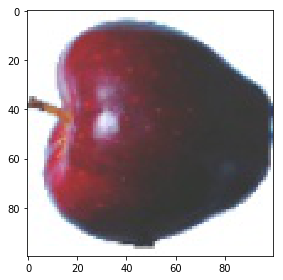

In [116]:
i=19
imshow(X_train[i])
print(Y_train[i])

0
Kaki
69
69
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0.]
1
Clementine
35
35
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
2
Limes
50
50
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
3
Apple Golden 2
16
16
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
4
Apple Braeburn
40
40


/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


Maracuja
29
29
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
22
Apple Golden 2
16
16
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
23
Granadilla
10
10
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
24
Strawberry Wedge
20
20
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
25
Pepi

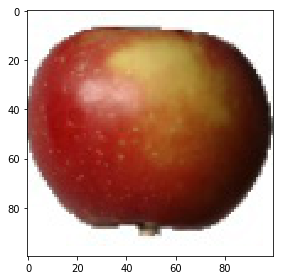

In [115]:
for t in range(30):
    print(t)
    imshow(class_list[t]['data'])
    print(class_list[t]['class_name'])
    print(class_list[t]['class_num'])
    print(before_y[t])
    print(Y_train[t])

### データ準備関数（リサイズあり）

In [3]:
from PIL import Image

In [4]:
def data_prepare_with_resize(limit, TRAIN_PATH = 'input/fruits-360/Training/',shape=[100,100]):
    
    train_ids = next(os.walk(TRAIN_PATH))[1]
    #train_idsから番号と文字列を取り出す
    num_and_name = dict()
    for n in range(len(train_ids)):
        #振り分け番号
        num_and_name[n] = train_ids[n]

    IMG_CHANNELS = 3
    class_list=[]
    data_count_each_class=[]
    data_num = 0
    
    for i in range(len(train_ids)):
        data_count = dict()
        data_count['class_num'] = i
        data_count['class_name'] = train_ids[i]
        path1 = TRAIN_PATH + train_ids[i]
        pic_id = next(os.walk(path1))
        num_in_class = 0
        for t in range(len(pic_id[2])):
            num_in_class += 1 #そのクラスのデータ数をカウント
            if t < limit:     
                num_and_name = dict()
                num_and_name['class_num'] = i #そのデータの所属クラス番号
                num_and_name['class_name'] = train_ids[i] #そのデータの所属クラス名
                img = Image.open(path1 +'/'+ pic_id[2][t])
                num_and_name['data'] = img.resize((shape[0], shape[1]))
                class_list.append(num_and_name)
                data_num += 1 #使用する全データの数
        data_count['data_count'] = num_in_class
        data_count_each_class.append(data_count)

        random.shuffle(class_list)

    X_train = np.zeros((data_num, shape[0], shape[1], IMG_CHANNELS),dtype=np.uint8)
    Y_train = np.zeros(data_num,dtype=np.uint8)
    
    for i in range(data_num):
        X_train[i] = class_list[i]['data']
        Y_train[i] = class_list[i]['class_num']
    
    one_hot_y = np_utils.to_categorical(Y_train)
    
    return X_train, one_hot_y, class_list, data_count_each_class


### 自作CNNモデル

In [14]:
def net_builder(input_d1, input_d2, input_d3, optimizer='adam', loss_func='categorical_crossentropy'):
    inputs = Input(shape=(input_d1, input_d2, input_d3))
    s = Lambda(lambda x: x / 255.0)(inputs)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(s)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p2 = MaxPooling2D((2,2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    p3 = MaxPooling2D((2,2))(c6)
    
    flat = Flatten()(p3)
    d1 = Dense(512, activation='relu')(flat)
    d2 = Dense(74, activation='softmax')(d1)

    
    model = Model(inputs=[inputs], outputs=[d2])
    
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
    model.summary()
    return model


def model_fit(model, x, y, epochs=5, batch_size=10, fit_verbose=1, validation_split=0.2, patience=5):
    earlystop = EarlyStopping(patience=patience)
    callbacks = [earlystop]
    model.fit(x=x, y=y, epochs=epochs, batch_size=batch_size, verbose=fit_verbose, callbacks=callbacks, validation_split=validation_split)
    return model


def model_eval(model, x, y, batch_size=8):
    eval_result = model.evaluate(x=x, y=y, batch_size=batch_size)
    return eval_result


#### 学習データ準備

In [6]:
X_train, Y_train, class_list, data_count = data_prepare(1000)

#### モデル作成

In [15]:
net = net_builder(100,100,3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 128)       147584    
__________

#### 学習実施

In [16]:
fitted_model = model_fit(net,X_train,Y_train, batch_size=50, epochs=5)

Train on 29680 samples, validate on 7421 samples
Epoch 1/5
29680/29680 [==============================] - 159s 5ms/step - loss: 0.6335 - acc: 0.8324 - val_loss: 0.0622 - val_acc: 0.9806
Epoch 2/5
29680/29680 [==============================] - 158s 5ms/step - loss: 0.0544 - acc: 0.9818 - val_loss: 0.5420 - val_acc: 0.8485
Epoch 3/5
29680/29680 [==============================] - 159s 5ms/step - loss: 0.2175 - acc: 0.9702 - val_loss: 0.0335 - val_acc: 0.9904
Epoch 4/5
29680/29680 [==============================] - 159s 5ms/step - loss: 0.0198 - acc: 0.9918 - val_loss: 0.0137 - val_acc: 0.9923
Epoch 5/5
29680/29680 [==============================] - 158s 5ms/step - loss: 0.0112 - acc: 0.9936 - val_loss: 0.0128 - val_acc: 0.9915


#### 評価データ準備

In [18]:
X_test, Y_test, class_list_t, data_count_t = data_prepare(1000,'input/fruits-360/Test/')

#### 評価実施

In [19]:
eval_result = model_eval(fitted_model,x=X_test, y=Y_test)
print("loss:{0},accuracy:{1}".format(eval_result[0], eval_result[1]))

12460/12460 [==============================] - 32s 3ms/step
loss:0.27163917363951384,accuracy:0.9468699839486356


## VGG16 転移学習

In [19]:
from keras.applications.vgg16 import VGG16

In [20]:
base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(100,100,3)))

In [21]:
x=base_model.output
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
dout=Dense(74,activation='softmax')(x)
t_model=Model(inputs=base_model.input,outputs=dout)

for layer in base_model.layers[:19]:
    layer.trainable=False

t_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

t_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [80]:
for i ,la in enumerate(t_model.layers):
    print(i ,la.name)

0 input_14
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_18
20 dense_35
21 dense_36


In [22]:
X_train_VGG16, Y_train_VGG16, class_list, data_count = data_prepare(1000)

In [45]:
X_train.shape

(37101, 100, 100, 3)

In [24]:
X_train_VGG16 = X_train_VGG16/255.0

In [23]:
t_model.fit(x=X_train_VGG16/255, y=Y_train_VGG16 ,batch_size=100, epochs=5, validation_split=0.2)

Train on 29680 samples, validate on 7421 samples
Epoch 1/5
29680/29680 [==============================] - 92s 3ms/step - loss: 0.3919 - acc: 0.9205 - val_loss: 0.0810 - val_acc: 0.9856
Epoch 2/5
29680/29680 [==============================] - 88s 3ms/step - loss: 0.0272 - acc: 0.9935 - val_loss: 0.0249 - val_acc: 0.9925
Epoch 3/5
29680/29680 [==============================] - 89s 3ms/step - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0151 - val_acc: 0.9933
Epoch 4/5
29680/29680 [==============================] - 88s 3ms/step - loss: 0.0139 - acc: 0.9940 - val_loss: 0.0223 - val_acc: 0.9918
Epoch 5/5
29680/29680 [==============================] - 88s 3ms/step - loss: 0.0115 - acc: 0.9943 - val_loss: 0.0129 - val_acc: 0.9930


#### 評価実施

In [25]:
t_model.save('transfer_VGG16.h5')

In [26]:
del X_train_VGG16, Y_train_VGG16

In [27]:
X_test_VGG16, Y_test_VGG16, _, __ = data_prepare(1000,'input/fruits-360/Test/')

In [27]:
X_train_VGG16 = X_train_VGG16/255.0

In [28]:
t_test_result = t_model.evaluate(x=X_test_VGG16/255, y=Y_test_VGG16, batch_size=100)
t_test_result

12460/12460 [==============================] - 29s 2ms/step


[0.0761189524556718, 0.9750401388202012]

## ResNet50 転移学習

In [5]:
from keras.applications.resnet50 import ResNet50

In [6]:
base_model2 = ResNet50(include_top=False, weights='imagenet', input_shape=(200,200,3))

In [7]:
x2 = base_model2.output
flat = Flatten()(x2)
x2 = Dense(1024, activation='relu')(flat)
x2 = Dense(74, activation='softmax')(x2)
model2 = Model(inputs=base_model2.input, outputs=x2)

for layer in model2.layers[:175]:
    if 'bn' in layer.name:
        layer.trainable=True
    else:
        layer.trainable=False
    
model2.layers[176].trainable=True
model2.layers[177].trainable=True
    
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
for i ,la in enumerate(model2.layers):
    print(i ,la.name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 activatio

#### 学習データ準備

In [8]:
X_train_Res, Y_train_Res, _, __ = data_prepare_with_resize(1000,shape=[200,200])

In [ ]:
X_train_Res = X_train_Res/255

In [52]:
del X_train, X_train_VGG16 , X_test , X_test_VGG16

In [57]:
del X_train_Res

In [55]:
import gc
gc.collect()

589

In [ ]:
X_train_Res = X_train_Res/255.0

#### 学習実施

In [9]:
model2.fit(x=X_train_Res/255, y=Y_train_Res, batch_size=100, epochs=5, validation_split=0.2, verbose=1)

Train on 29680 samples, validate on 7421 samples
Epoch 1/5
29680/29680 [==============================] - 581s 20ms/step - loss: 0.1432 - acc: 0.9667 - val_loss: 0.0105 - val_acc: 0.9947
Epoch 2/5
29680/29680 [==============================] - 571s 19ms/step - loss: 0.0148 - acc: 0.9941 - val_loss: 0.0091 - val_acc: 0.9953
Epoch 3/5
29680/29680 [==============================] - 567s 19ms/step - loss: 0.0088 - acc: 0.9958 - val_loss: 0.0119 - val_acc: 0.9945
Epoch 4/5
29680/29680 [==============================] - 580s 20ms/step - loss: 0.0071 - acc: 0.9971 - val_loss: 0.0061 - val_acc: 0.9969
Epoch 5/5
29680/29680 [==============================] - 582s 20ms/step - loss: 0.0276 - acc: 0.9925 - val_loss: 0.0321 - val_acc: 0.9877


In [10]:
model2.save('transfer_ResNet.h5') 

In [11]:
del X_train_Res

In [12]:
del Y_train_Res

#### 評価データ準備

In [14]:
X_test_Res, Y_test_Res, _, __ = data_prepare_with_resize(1000,'input/fruits-360/Test/', shape=[200,200])

In [ ]:
X_test_Res = X_test_Res/255.0

#### 評価実施

In [15]:
model2_result = model2.evaluate(x=X_test_Res/255, y=Y_test_Res, batch_size=100)
print("loss:{0},accuracy:{1}".format(model2_result[0], model2_result[1]))

12460/12460 [==============================] - 111s 9ms/step
loss:0.135333041312176,accuracy:0.9653290575235651


In [16]:
del X_test_Res, Y_test_Res